In [1]:
import os
from pathlib import Path
from IPython import get_ipython

if get_ipython().execution_count == 1:
    parent_dir = Path.cwd().parent.resolve()
    os.chdir(parent_dir)

In [2]:
from src.data.manager import *
from src.data.transform import *
from src.data.features import *
from src.data.strategy import *
from src.model import *
from src.universe import *

universe = Universe(['AAPL'])
data_manager = DataManager(universe, load_lazy=True)

Transformer(data_manager)['AAPL']('scale_by_splits', splits={
    "1987-06-16": 2,
    "2000-06-21": 2,
    "2005-02-28": 2,
    "2014-06-09": 7,
    "2020-08-31": 4
})
Transformer(data_manager)('drop_stale_options', volume_threshold=100)
Transformer(data_manager)('filter_ttms', min_ttm=7)
Transformer(data_manager)('train_test_split', test_size=0.35, drop_out_of_sample=True)
Transformer(data_manager)('implied_volatility')
Transformer(data_manager)('mid_price')
Features(data_manager)('forward_vol_ratio', near_ttm=30, far_ttm=60)
Strategy(data_manager)(
    'butterfly_spread',
    ttm=30,
    hold_days=20,
    lower_delta=0.25,
    upper_delta=0.75,
    name='30_day_butterfly',
    collapse_trades=True
    )
Transformer(data_manager)('prepare_data',
    features = [('forward_vol_ratio', {'groupby': 'trade_date', 'how': 'mean'})],
    target = ('30_day_butterfly', {'groupby': 'trade_date', 'how': 'sum'}),
    filters = {
        'forward_vol_ratio': ('null',),
        '30_day_butterfly': ('null',)
    },

)
LinearRegression(data_manager)(
    'fit_predict',
    X_cols=['forward_vol_ratio'],
    y_col='30_day_butterfly',
    logistic_threshold = 0.1,
    name='linear_regression_prediction',
    save_params=True
)
LogisticRegression(data_manager)(
    'fit_predict',
    X_cols=['forward_vol_ratio'],
    y_col='30_day_butterfly',
    threshold = 0.0,
    name='logistic_regression_prediction',
    save_params=True
)
MultiLayerPerceptron(data_manager)(
    'fit_predict',
    X_cols=['forward_vol_ratio'],
    y_col='30_day_butterfly',
    hidden_layers = (4, 4),
    name='multi_layer_perceptron_prediction',
    save_params=True
)

data_manager.execute_pipeline(retain_data=True, save_data=True)

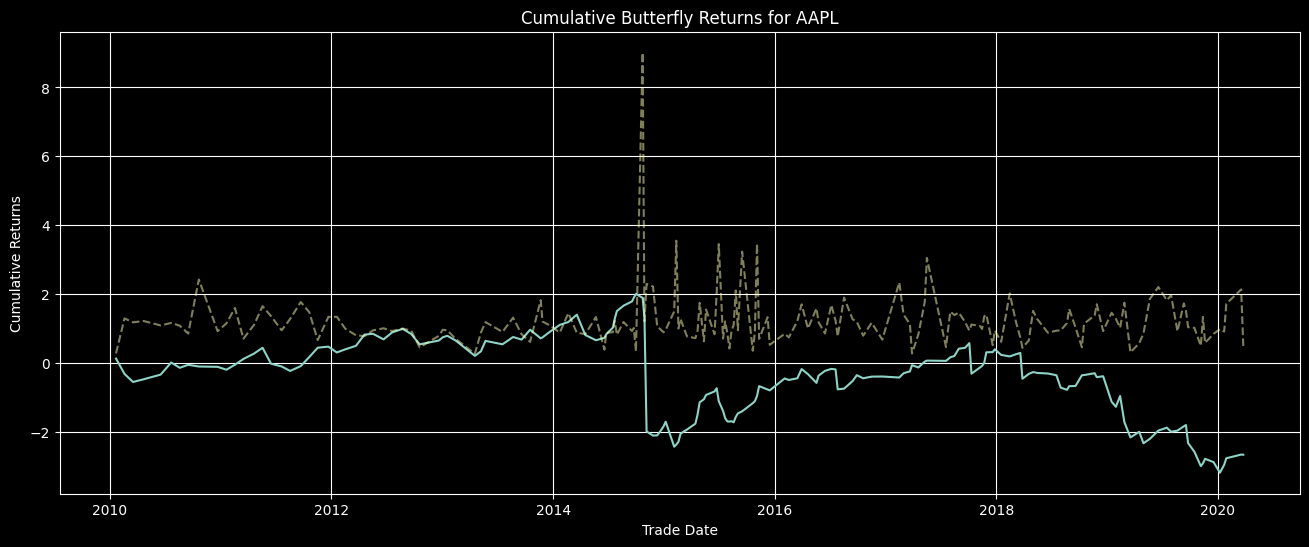

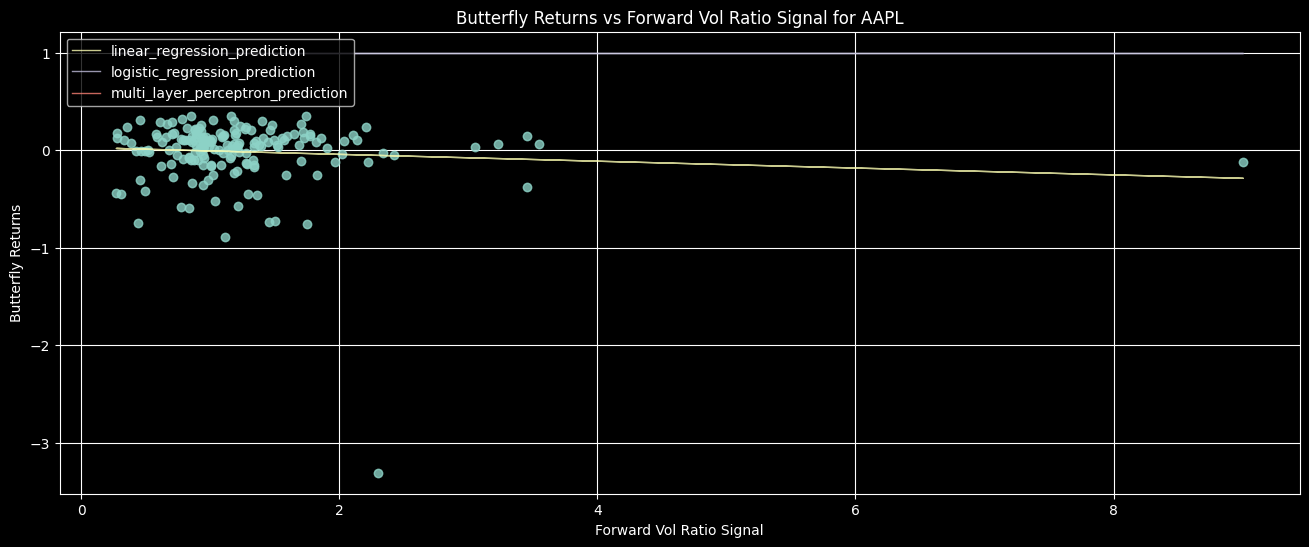

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor, RANSACRegressor, LinearRegression
import numpy as np

X = data_manager.outputs['AAPL']['forward_vol_ratio'].values.reshape(-1,1)
y_preds = [data_manager.outputs['AAPL'][name].values for name in data_manager.outputs['AAPL'].columns if 'prediction' in name]
y = data_manager.outputs['AAPL']['30_day_butterfly'].values


plt.style.use('dark_background')
plt.figure(figsize=(16,6))
sorted_dates = pd.to_datetime(data_manager.outputs['AAPL']['trade_date']).sort_values()

plt.plot(sorted_dates, data_manager.outputs['AAPL']['30_day_butterfly'].cumsum(), linestyle='-')
plt.plot(sorted_dates, data_manager.outputs['AAPL']['forward_vol_ratio'], linestyle='--', alpha=0.5)

plt.title('Cumulative Butterfly Returns for AAPL')
plt.xlabel('Trade Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

plt.figure(figsize=(16,6))
plt.plot(data_manager.outputs['AAPL']['forward_vol_ratio'], data_manager.outputs['AAPL']['30_day_butterfly'], linestyle='None', marker='o', alpha=0.7)
for y_pred, name in zip(y_preds, [name for name in data_manager.outputs['AAPL'].columns if 'prediction' in name]):
    plt.plot(data_manager.outputs['AAPL']['forward_vol_ratio'], y_pred,  linewidth=1, label=name, alpha=0.8)

plt.scatter(X, y, alpha=0.3)

plt.legend(loc='upper left')    
plt.title('Butterfly Returns vs Forward Vol Ratio Signal for AAPL')
plt.xlabel('Forward Vol Ratio Signal')
plt.ylabel('Butterfly Returns')
plt.grid(True)
plt.show()


In [5]:
data_manager.outputs['AAPL']

,trade_date,forward_vol_ratio,30_day_butterfly,linear_regression_prediction,logistic_regression_prediction,multi_layer_perceptron_prediction
12,2010-01-21,0.279951,0.128809,0.017997,1,NaN
31,2010-02-18,1.294815,-0.445958,-0.017615,1,NaN
51,2010-03-18,1.180065,-0.233522,-0.013588,1,NaN
75,2010-04-22,1.219336,0.078410,-0.014966,1,NaN
114,2010-06-17,1.090936,0.135173,-0.010461,1,NaN
...,...,...,...,...,...,...
2521,2020-01-08,0.980456,-0.307035,-0.006584,1,NaN
2530,2020-01-22,0.911978,0.230869,-0.004181,1,NaN
2535,2020-01-29,1.718062,0.188561,-0.032467,1,NaN
2569,2020-03-18,2.135684,0.107841,-0.047121,1,NaN
